- lstm 모델을 사용한 날씨 예측
    - 날씨 시계열 데이터 사용
    - 단일변수(온도)로 온도 예측

##### The weather dataset
날씨 데이터 세트
날씨 시계열 데이터 세트를 사용

In [19]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize']=(8,6)
mpl.rcParams['axes.grid']=False

In [20]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname = 'jena_climate_2009_2016.csv.zip',
    extract=True
)
csv_path, _ = os.path.splitext(zip_path)
print(csv_path)

C:\Users\서지희\.keras\datasets\jena_climate_2009_2016.csv


In [21]:
#pandas dataframe으로 csv 파일 read
df= pd.read_csv(csv_path)

In [22]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


## 데이터 윈도우
데이터의 연속 샘플 창을 기반으로 일련의 예측을 수행
6시간의 히스토리가 주어졌을 때 미래는 1시간으로 예측하는 모델에 사용되는 데이터 윈도우
- 날씨 데이터의 예
        5일간 관측값을 이용하여 미래의 6시간 동안 온도를 예측하기 위한 데이터 윈도우
        특정 시간을 기준으로 과거정보(history)에 해당하는 720(5*144) 관측 값이 입력 데이터 window로 설정되고
        특정시간 이후의 36개 (6*6) 관측값이 출력 라벨(target label)로 설정

- 데이터 윈도우 생성 함수
    - univariate_data()
        모델이 학습할 때 사용할 데이터 window를 반환(data, label)
        매개 변수
            - history_size: 과거 정보 window_size, 입력 데이터 크기
            - target_size: 출력 라벨(target label), 예측라벨 크기

In [23]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index=start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i + target_size])
    return np.array(data), np.array(labels)

단일 특징(온도, temperature)만 사용하여 모델을 만들고 해당 값을 예측

In [24]:
#(1) 데이터셋에서 온도만 추출
uni_data = df['T (degC)']
uni_data.index = df['Date Time']
uni_data.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

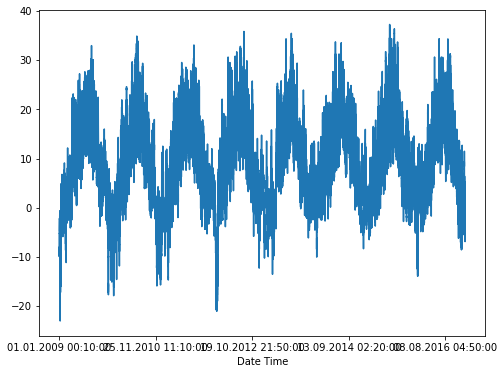

In [25]:
#(2) 시간에 따른 온도 시각화
uni_data.plot(subplots = True)
plt.show()

## Standardization
- 평균, 표준편차를 구하여 스케일링 처리
- keras.utils.normalize를 이용하여 [0,1] 범위로 재종하는 방법을 사용해도 됨

In [26]:
# uni_data에서 값만 추출
uni_data = uni_data.values

In [27]:
# 데이터의 처음 300,000개 행은 학습 데이터 세트(2100분량)이고 나머지는 유효성 검사 데이터 세트로 구성
TRAIN_SPLIT = 300000

# 재현성을 보장하기 위해 시드 설정
tf.random.set_seed(13)

In [28]:
#평균, 표준편차 구하기
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

# 표준화
uni_data = (uni_data - uni_train_mean)/uni_train_std

## univariate_data 추출
지난 20개의 온도 관측 기록을 사용하여 현재 시간 온도 예측을 위한 데이터 추출
- window 추출
    x:지난 20개의 온도 관측값
    y: 현재시간의 관측값

In [29]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

- 예측 결과 plotting 함수 정의

In [30]:
def create_time_steps(length):
    return list(range(-length, 0))

In [35]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize = 10,
                     label = labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label = labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

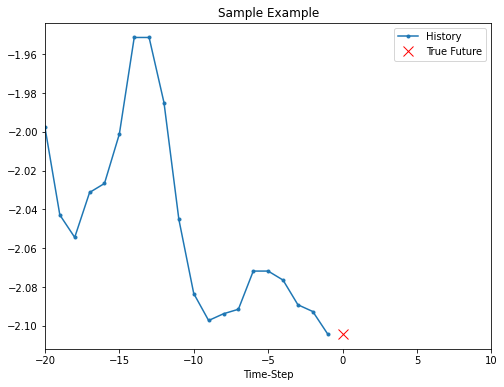

In [37]:
#0  번째 학습 데이터에 대한 플로팅
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')
plt.show()

## Baseline
모델 학습 전에 기준선 설정, 과거 20개 관측값의 평균점을 모델 예측으로 정하여 출력

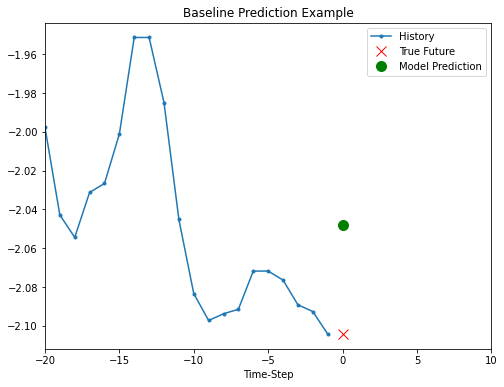

In [38]:
#평균값의 예측 기준값으로 계산
def baseline(history):
    return np.mean(history)

# 입력(history), 라벨(larget), 예측(baseline)에 대한 플로팅
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
          'Baseline Prediction Example')
plt.show()

## LSTM 데이터 입력 구조


In [ ]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

#train, validation data를 텐서로 변경하여 batch size만큼 추출
train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

## LSTM model 구성

In [40]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

## sample prediction
검증데이터 1개를 가져와서 예측한 출력 결과 확인

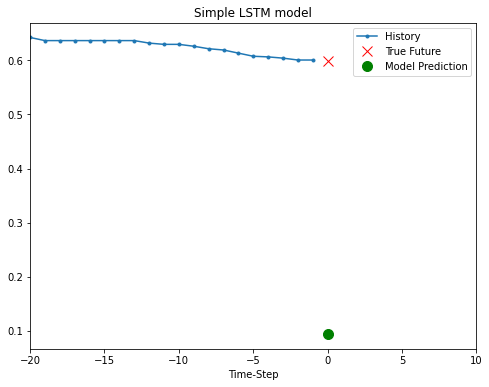

In [41]:
for x, y in val_univariate.take(1):
    plot = show_plot([x[0].numpy(), y[0].numpy(),
                      simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
    plot.show()

## train the model

In [43]:
EVALUATION_INTERVAL = 200
EPOCHS=10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Epoch 1/10
200/200 [==============================] - 3s 8ms/step - loss: 0.5855 - val_loss: 0.1351

## Predict using the simple LSTM model
학습된 simple LSTM으로 예측결과 확인

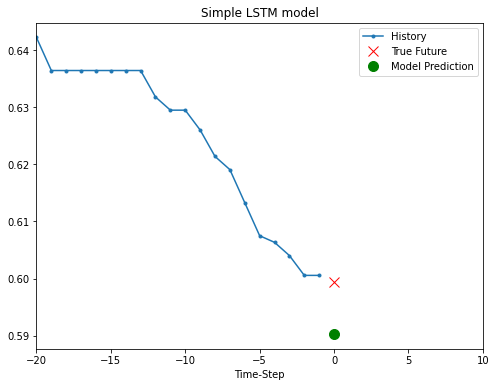

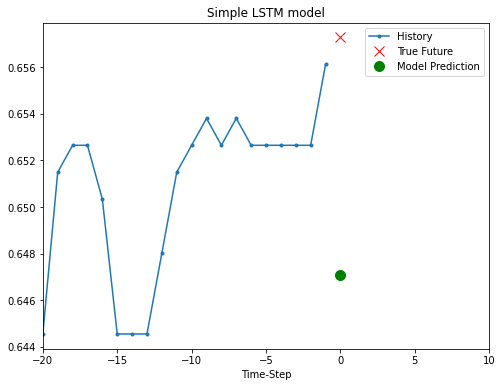

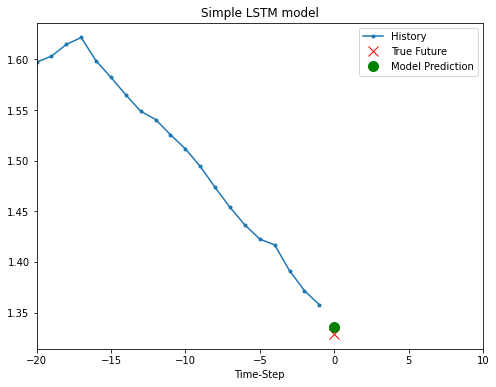

In [44]:
for x, y in val_univariate.take(3):
    plot = show_plot([x[0].numpy(), y[0].numpy(),
                      simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')

    plt.show()